Heptane–Ethylbenzene (Problem 26.4-2)
xF = 0.420000, xD = 0.970000, xW = 0.011000

--- Minimum reflux ratio (graphical) ---
Pinch point at q-line ∩ equilibrium: (x_p, y_p) = (0.420000, 0.670255)
Rectifying slope at Rmin: m_Rmin = 0.544990
Rmin = 1.197755

--- Minimum stages at total reflux (graphical) ---
Steps including reboiler = 7.892144
Theoretical trays excluding reboiler = 6.892144

--- (Context) Actual at R = 2.5 from your earlier run ---
D = 85.297 mol/h, W = 114.703 mol/h
Steps including reboiler = 11.860939
Trays excluding reboiler = 10.860939
Feed tray from top = 6, trays above feed = 5


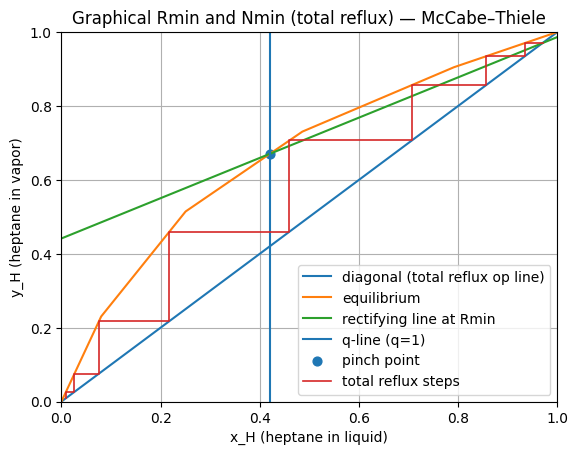

In [1]:
# notebooks/26.4_4.py

import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, "..")

from bank.Distillation.distillation_mccabe_thiele_xy_base import (
    XYEquilibrium,
    McCabeThieleXYSpec,
    solve_mccabe_thiele_xy,
    step_off_stages_xy,              # used for total reflux (diagonal operating line)
)

# ============================================================
# Problem 26.4-2 data (heptane = light component)
# ============================================================
F  = 200.0
zF = 0.42
xD = 0.97
xW = 0.011
q  = 1.0  # saturated liquid (vertical q-line at x=xF)

x_eq = [0.000, 0.080, 0.250, 0.485, 0.790, 1.000]
y_eq = [0.000, 0.230, 0.514, 0.730, 0.904, 1.000]
eq = XYEquilibrium(x=x_eq, y=y_eq)

# ============================================================
# (1) Minimum reflux ratio Rmin (graphical McCabe–Thiele)
# For q = 1 (vertical q-line), pinch point is at x = xF on equilibrium:
#   pinch = (xF, y_eq(xF))
# Rectifying line at minimum reflux passes through (xD, xD) and pinch.
# Rectifying slope m = R/(R+1)  =>  R = m/(1-m)
# ============================================================
xF = zF
y_pinch = eq.y_of_x(xF)

m_Rmin = (y_pinch - xD) / (xF - xD)  # slope of line through (xD,xD) and pinch
Rmin = m_Rmin / (1.0 - m_Rmin)

# ============================================================
# (2) Minimum stages at total reflux (graphical McCabe–Thiele)
# At total reflux, operating lines collapse to the diagonal y = x.
# Do staircase between equilibrium curve and diagonal.
#
# Using bank stepper by setting BOTH operating lines to diagonal:
#   rect: y = 1*x + 0
#   strip: y = 1*x + 0
# x_int can be any value in (0,1); switching is irrelevant when both lines identical.
#
# Note: stepper returns "N_theoretical" as steps including the reboiler-equilibrium step.
# If you report trays excluding reboiler: N_trays = N_steps - 1
# ============================================================
rect_diag = (1.0, 0.0)
strip_diag = (1.0, 0.0)

stepping_total_reflux = step_off_stages_xy(
    eq=eq,
    x_D=xD,
    x_W=xW,
    rect=rect_diag,
    strip=strip_diag,
    x_int=xF,          # irrelevant for total reflux but must be provided
    max_stages=2000,
)

N_steps_total_reflux = stepping_total_reflux["N_theoretical"]
N_trays_total_reflux = N_steps_total_reflux - 1.0  # trays excluding reboiler

# ============================================================
# (Optional) Also compute actual case stages at R=2.5 (for context)
# ============================================================
R_actual = 2.5
out_actual = solve_mccabe_thiele_xy(
    McCabeThieleXYSpec(
        eq=eq,
        F=F,
        zF=zF,
        x_D=xD,
        x_W=xW,
        R=R_actual,
        q=q,
        max_stages=1500,
    )
)

# ============================================================
# Print results
# ============================================================
print("============================================================")
print("Heptane–Ethylbenzene (Problem 26.4-2)")
print("============================================================")
print(f"xF = {xF:.6f}, xD = {xD:.6f}, xW = {xW:.6f}")
print("\n--- Minimum reflux ratio (graphical) ---")
print(f"Pinch point at q-line ∩ equilibrium: (x_p, y_p) = ({xF:.6f}, {y_pinch:.6f})")
print(f"Rectifying slope at Rmin: m_Rmin = {m_Rmin:.6f}")
print(f"Rmin = {Rmin:.6f}")

print("\n--- Minimum stages at total reflux (graphical) ---")
print(f"Steps including reboiler = {N_steps_total_reflux:.6f}")
print(f"Theoretical trays excluding reboiler = {N_trays_total_reflux:.6f}")

print("\n--- (Context) Actual at R = 2.5 from your earlier run ---")
print(f"D = {out_actual['flows']['D']:.3f} mol/h, W = {out_actual['flows']['W']:.3f} mol/h")
print(f"Steps including reboiler = {out_actual['stages']['N_theoretical']:.6f}")
print(f"Trays excluding reboiler = {out_actual['stages']['N_theoretical'] - 1.0:.6f}")
print(f"Feed tray from top = {out_actual['feed']['feed_tray_from_top']}, trays above feed = {out_actual['feed']['N_rect']}")

# ============================================================
# Plots (optional): equilibrium + diagonal + pinch line + steps
# ============================================================
xs = np.linspace(0, 1, 600)
yeq = np.array([eq.y_of_x(float(x)) for x in xs])

# line through (xD,xD) and pinch (Rmin rectifying line)
b_Rmin = xD - m_Rmin * xD
y_Rmin = m_Rmin * xs + b_Rmin

pts_tr = np.array(stepping_total_reflux["points_xy"], dtype=float)

plt.figure()
plt.plot(xs, xs, label="diagonal (total reflux op line)")
plt.plot(xs, yeq, label="equilibrium")
plt.plot(xs, y_Rmin, label="rectifying line at Rmin")
plt.axvline(x=xF, label="q-line (q=1)")
plt.scatter([xF], [y_pinch], s=40, label="pinch point")
plt.plot(pts_tr[:, 0], pts_tr[:, 1], linewidth=1.2, label="total reflux steps")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel("x_H (heptane in liquid)")
plt.ylabel("y_H (heptane in vapor)")
plt.title("Graphical Rmin and Nmin (total reflux) — McCabe–Thiele")
plt.legend()
plt.show()